In [8]:
#Library Imports
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize

#Utility Function Imports
from utilities import *

#Algorithm Imports
from Strategies.benchmarks import *
from Strategies.follow_the_loser import *
from Strategies.follow_the_winner import *
from Strategies.pattern_matching import *
from Strategies.meta_learning import *

pd.set_option('future.no_silent_downcasting', True)

In [9]:
folder_path = "C:\\Users\\nlaha\\OneDrive\\Documents\\Personal\\Quant Research\\Trading Data\\"
tickers = ['aapl','msft','nvda']
b = initialize_portfolio(len(tickers))

price_relative_df = calculate_price_relative_vectors(folder_path, tickers)
price_relative_vectors_array = price_relative_df.values
dates = price_relative_df.index

# Example of just using Follow the Leading History
b_n = follow_the_leading_history(b, price_relative_vectors_array)
Sn = calculate_cumulative_wealth(b_n, price_relative_vectors_array)
Wn = calculate_exponential_growth_rate(Sn, len(price_relative_vectors_array))

print("Final wealth (Follow the Leading History):", Sn)
print("Exponential growth rate:", Wn)

NameError: name 'project_to_simplex' is not defined

Running strategy: Buy and Hold
Running strategy: Best Stock
Running strategy: Constant Rebalancing
Running strategy: Universal Portfolios
Running strategy: Exponential Gradient
Running strategy: Follow the Leader
Running strategy: Follow the Regularized Leader
Running strategy: Aggregation-Based_Simple
Running strategy: Anti-Correlation
Running strategy: PAMR
Running strategy: CWMR
Running strategy: OLMAR
Running strategy: RMR
Running strategy: Aggregation-Based_Generalized
Running strategy: Fast Universalization
Running strategy: OGU
Running strategy: ONU
Running strategy: Follow the Leading History
Running strategy: Histogram-Based Selection + Log-Optimal Portfolio
Running strategy: Histogram-Based Selection + Semi-Log-Optimal Portfolio
Running strategy: Histogram-Based Selection + Markowitz Portfolio
Running strategy: Kernel-Based Selection + Log-Optimal Portfolio
Running strategy: Kernel-Based Selection + Semi-Log-Optimal Portfolio
Running strategy: Kernel-Based Selection + Markowi

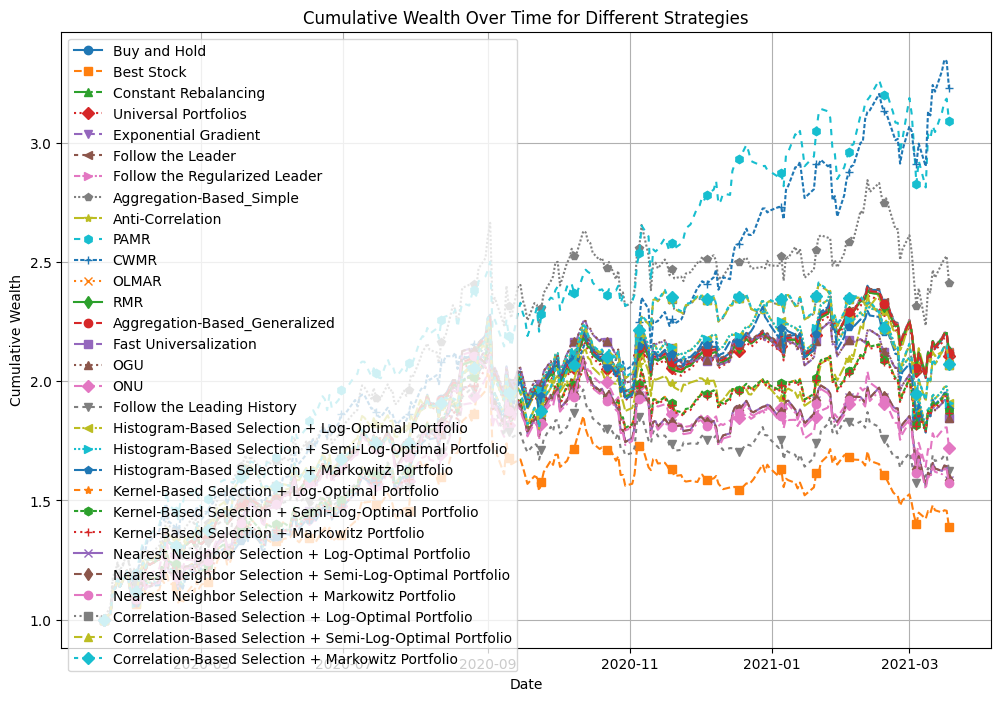

In [13]:
  # VISUALIZATION
import matplotlib.pyplot as plt
strategies = {
    'Buy and Hold': buy_and_hold,
    'Best Stock': best_stock,
    'Constant Rebalancing': constant_rebalancing,
    'Universal Portfolios': universal_portfolios,
    'Exponential Gradient': exponential_gradient,
    'Follow the Leader': follow_the_leader,
    'Follow the Regularized Leader': follow_the_regularized_leader,
    'Aggregation-Based_Simple': aggregation_based_simple,
    'Anti-Correlation': anticor,
    'PAMR': pamr,
    'CWMR': cwmr,
    'OLMAR': olmar,
    'RMR': rmr,
    "Aggregation-Based_Generalized" : aggregation_algorithm_generalized,
    "Fast Universalization" : fast_universalization,
    "OGU": online_gradient_update_meta,
    "ONU": online_newton_update_meta,
    "Follow the Leading History": follow_the_leading_history
    }

    # Pattern-Matching combos
sample_selection_methods = {
        'Histogram-Based Selection': histogram_based_selection,
        'Kernel-Based Selection': kernel_based_selection,
        'Nearest Neighbor Selection': nearest_neighbor_selection,
        'Correlation-Based Selection': correlation_based_selection
    }
portfolio_optimization_methods = {
        'Log-Optimal Portfolio': log_optimal_portfolio,
        'Semi-Log-Optimal Portfolio': semi_log_optimal_portfolio,
        'Markowitz Portfolio': markowitz_portfolio
    }
combos = []
for ss_name, ss_func in sample_selection_methods.items():
    for po_name, po_func in portfolio_optimization_methods.items():
        combination_name = f"{ss_name} + {po_name}"
        combos.append((combination_name, ss_func, po_func))

    # Add pattern-matching combos
for combination_name, ss_func, po_func in combos:
    def make_pattern_matching_strategy(ss=ss_func, po=po_func):
        def strategy(b, price_rels):
            methods = {'sample_selection': ss, 'portfolio_optimization': po}
            return pattern_matching_portfolio_master(b, price_rels, methods)
        return strategy
    strategies[combination_name] = make_pattern_matching_strategy()

cumulative_wealth_dict = {}
line_styles = ['-', '--', '-.', ':',
                   (0,(4,2)), (0,(2,2)), (0,(3,1,1,1)), (0,(1,1)),
                   (0,(5,1)), (0,(3,3)), (0,(2,1)), (0,(1,2,1,2))]
markers = ['o','s','^','D','v','<','>','p','*','h','+','x','d']

num_strategies = len(strategies)
if len(line_styles) < num_strategies:
    line_styles *= (num_strategies//len(line_styles)+1)
if len(markers) < num_strategies:
    markers *= (num_strategies//len(markers)+1)

plt.figure(figsize=(12,8))

for i, (strategy_name, strategy_function) in enumerate(strategies.items()):
    try:
        print(f"Running strategy: {strategy_name}")
        b_n_strat = strategy_function(b, price_relative_vectors_array)
        cum_wealth = calculate_cumulative_wealth_over_time(b_n_strat, price_relative_vectors_array)
        cumulative_wealth_dict[strategy_name] = cum_wealth
    except Exception as e:
        print(f"Error in {strategy_name}: {e}")
        continue

for i, (strategy_name, cum_wealth) in enumerate(cumulative_wealth_dict.items()):
    plt.plot(
        dates, cum_wealth,
        label=strategy_name,
        linestyle=line_styles[i],
        marker=markers[i],
        markevery=10,
        markersize=6,
        linewidth=1.5
    )

plt.title('Cumulative Wealth Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend()
plt.grid(True)
plt.show()